In [1]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [3]:
!kaggle datasets download -d janmejaybhoi/cotton-disease-dataset

 99% 147M/148M [00:08<00:00, 17.2MB/s]
100% 148M/148M [00:08<00:00, 17.5MB/s]


In [4]:
import zipfile
zip_ref = zipfile.ZipFile('/content/cotton-disease-dataset.zip', 'r')
zip_ref.extractall('/content/drive/MyDrive/cotton_plant_disease/')
zip_ref.close()

## Transfer Learning Resnet 50 using Keras

In [6]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [7]:
# import the libraries as shown below

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
#from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
#import matplotlib.pyplot as plt

In [9]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path = '/content/drive/MyDrive/cotton_plant_disease/Dataset/train'
valid_path = '/content/drive/MyDrive/cotton_plant_disease/Dataset/test'

In [10]:
# Import the Resnet 50 library as shown below and add preprocessing layer to the front of Resnet
# Here we will be using imagenet weights

resnet = ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

94765736/94765736 [==============================] - 5s 0us/step


In [11]:
# don't train existing weights
for layer in resnet.layers:
    layer.trainable = False

In [12]:
  # useful for getting number of output classes
folders = glob('/content/drive/MyDrive/cotton_plant_disease/Dataset/train/*')

In [13]:
# our layers - you can add more if you want
x = Flatten()(resnet.output)

In [14]:
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=resnet.input, outputs=prediction)

In [15]:
# view the structure of the model
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [16]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [17]:
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [18]:
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory('/content/drive/MyDrive/cotton_plant_disease/Dataset/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 1951 images belonging to 4 classes.


In [19]:
test_set = test_datagen.flow_from_directory('/content/drive/MyDrive/cotton_plant_disease/Dataset/test',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 106 images belonging to 4 classes.


In [20]:
# fit the model
# Run the cell. It will take some time to execute
history = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=20,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

<ipython-input-20-3ce107b6e306>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/20
61/61 [==============================] - 51s 678ms/step - loss: 2.7133 - accuracy: 0.3931 - val_loss: 1.6582 - val_accuracy: 0.3302
Epoch 2/20
61/61 [==============================] - 38s 620ms/step - loss: 1.0728 - accuracy: 0.5505 - val_loss: 1.8130 - val_accuracy: 0.4906
Epoch 3/20
61/61 [==============================] - 37s 614ms/step - loss: 1.0256 - accuracy: 0.6064 - val_loss: 1.7334 - val_accuracy: 0.5094
Epoch 4/20
61/61 [==============================] - 37s 612ms/step - loss: 1.0078 - accuracy: 0.5864 - val_loss: 0.9574 - val_accuracy: 0.6132
Epoch 5/20
61/61 [==============================] - 37s 611ms/step - loss: 1.0406 - accuracy: 0.6089 - val_loss: 1.3797 - val_accuracy: 0.5660
Epoch 6/20
61/61 [==============================] - 37s 609ms/step - loss: 0.8837 - accuracy: 0.6643 - val_loss: 0.7872 - val_accuracy: 0.7453
Epoch 7/20
61/61 [==============================] - 38s 629ms/step - loss: 0.8975 - accuracy: 0.6873 - val_loss: 1.5740 - val_accuracy: 0.5377

In [21]:
import matplotlib.pyplot as plt

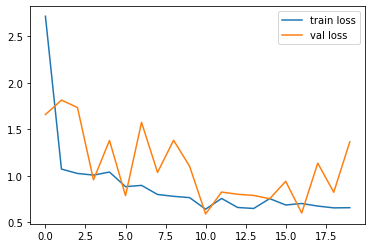

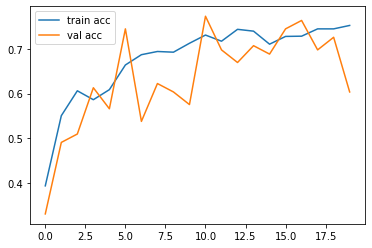

In [22]:
# plot the loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

# plot the accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

In [23]:
# save it as a h5 file


from tensorflow.keras.models import load_model

model.save('/content/drive/MyDrive/cotton_plant_disease/model_resnet50.h5')

In [24]:
y_pred = model.predict(test_set)

4/4 [==============================] - 4s 927ms/step


In [25]:
y_pred

array([[6.99724405e-05, 9.60910916e-01, 1.15116025e-04, 3.89039814e-02],
       [4.68271202e-04, 8.82706404e-01, 1.64203793e-02, 1.00404933e-01],
       [7.64223878e-05, 9.45322871e-01, 7.93465762e-04, 5.38072996e-02],
       [2.72102363e-04, 6.28970750e-03, 9.92317557e-01, 1.12062180e-03],
       [2.46389045e-05, 8.24446082e-01, 1.68941636e-03, 1.73839778e-01],
       [2.01505586e-03, 5.37385404e-01, 1.83100086e-02, 4.42289531e-01],
       [5.25601557e-04, 4.71193880e-01, 2.42110267e-01, 2.86170185e-01],
       [1.67548948e-04, 9.37252760e-01, 2.31413567e-03, 6.02655634e-02],
       [9.90233302e-01, 9.34161246e-03, 4.18968353e-04, 6.15162617e-06],
       [4.24645259e-04, 3.46248560e-02, 9.62386489e-01, 2.56394292e-03],
       [2.10056769e-05, 9.99566853e-01, 1.58892567e-06, 4.10587323e-04],
       [1.92838293e-02, 7.81167567e-01, 1.56949721e-02, 1.83853671e-01],
       [1.43727101e-03, 9.11715150e-01, 1.45629160e-02, 7.22847283e-02],
       [1.86757033e-03, 9.15553391e-01, 3.90284732e

In [26]:
import numpy as np
y_pred = np.argmax(y_pred, axis=1)

In [27]:
y_pred

array([1, 1, 1, 2, 1, 1, 1, 1, 0, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1,
       1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 1, 2, 2, 1, 1, 1, 2, 1,
       2, 1, 1, 2, 0, 2, 1, 2, 2, 3, 1, 1, 1, 0, 1, 1, 2, 1, 1, 2, 1, 1,
       1, 1, 1, 1, 3, 1, 0, 2, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 2, 1, 1,
       1, 0, 1, 1, 0, 2, 1, 1, 0, 2, 3, 3, 2, 2, 1, 0, 2, 3])

In [28]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

In [30]:
model=load_model('/content/drive/MyDrive/cotton_plant_disease/model_resnet50.h5')